In [42]:
! pip install xgboost

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing;
from sklearn import model_selection;
from sklearn import linear_model;
from sklearn.model_selection import train_test_split
from sqlalchemy import create_engine
import xgboost as xgb
import pandas as pd
import sqlite3

In [44]:
import sqlite3

# Create a SQL connection to our SQLite database
con = sqlite3.connect("portal_mammals.sqlite")

cur = con.cursor()

# The result of a "cursor.execute" can be iterated over by row
for row in cur.execute(''):
    print(row)

# Be sure to close the connection
con.close()

In [46]:
engine =create_engine('sqlite:///Earthquakedata.db')
df_features = pd.read_sql_table('Earthquake_features',con=engine)

In [ ]:
df_features.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-07-27,76.37,4.2,Papua New Guinea,-5.297074,148.894953,63.765909,67.072000,79.460000,4.550000,4.573333,4.500000,1
1,2020-07-28,88.76,4.3,Papua New Guinea,-5.297074,148.894953,61.451364,67.670000,78.664286,4.540909,4.393333,4.485714,1
2,2020-07-29,83.01,4.4,Papua New Guinea,-5.297074,148.894953,64.770000,66.487333,86.885714,4.545455,4.366667,4.485714,1
3,2020-07-30,10.00,4.9,Papua New Guinea,-5.297074,148.894953,64.770000,64.040000,85.245714,4.545455,4.426667,4.571429,1
4,2020-07-31,195.88,4.3,Papua New Guinea,-5.297074,148.894953,73.219091,75.197333,102.524286,4.531818,4.426667,4.500000,1


In [ ]:
engine =create_engine('sqlite:///Earthquakedata_predict.db')
df_predict = pd.read_sql_table('Earthquake_predict',con=engine)

In [ ]:
# Live data to be predicted on after being trained of rolling period for next 7 days. 
#Hence NaN outcome that has to be predicted

df_predict.head()

,date,depth,mag,place,latitude,longitude,depth_avg_22,depth_avg_15,depth_avg_7,mag_avg_22,mag_avg_15,mag_avg_7,mag_outcome
0,2020-08-03,140.81,4.4,Papua New Guinea,-5.297074,148.894953,73.251364,70.354000,83.355714,4.718182,4.820000,4.942857,NaN
1,2020-08-04,172.48,5.4,Papua New Guinea,-5.297074,148.894953,76.803636,75.935333,106.567143,4.763636,4.893333,4.857143,NaN
2,2020-08-05,94.65,5.0,Papua New Guinea,-5.297074,148.894953,79.948636,76.711333,105.600000,4.790909,4.933333,4.971429,NaN
3,2020-08-06,196.24,4.8,Papua New Guinea,-5.297074,148.894953,87.892273,89.127333,113.395714,4.813636,4.926667,5.071429,NaN
4,2020-08-06,85.48,4.7,Papua New Guinea,-5.297074,148.894953,88.371818,81.767333,124.178571,4.809091,4.953333,4.914286,NaN


In [ ]:
# Selection of features that are needed for prediction and hence consider only them rest are just ignored for prediction purpose.

features = [f for f in list(df_features) if f not in ['date', 'lon_box_mean',
 'lat_box_mean', 'mag_outcome', 'mag', 'place',
 'combo_box_mean',  'latitude',
 'longitude']]

# splitting training and testing dataset with trainging size = 70% and test = 30%
X_train, X_test, y_train, y_test = train_test_split(df_features[features],
                     df_features['mag_outcome'], test_size=0.3, random_state=42)

In [ ]:
features

['depth',
 'depth_avg_22',
 'depth_avg_15',
 'depth_avg_7',
 'mag_avg_22',
 'mag_avg_15',
 'mag_avg_7']

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV

param_grid = {
              "base_estimator__max_depth" :   [2,5,7],
              "n_estimators": [200, 400, 600]
             }

# base estimator
tree = DecisionTreeClassifier()

# adaboost with the tree as base estimator
# learning rate is arbitrarily set to 0.6,
ABC = AdaBoostClassifier(
    base_estimator=tree,
    learning_rate=0.6,
    algorithm="SAMME")

In [ ]:
# run grid search
grid_search_ABC = GridSearchCV(ABC,
                               param_grid=param_grid, 
                               scoring = 'roc_auc', 
                               return_train_score=True,                         
                               verbose = 1)

In [ ]:
grid_search_ABC.fit(X_train,y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3

GridSearchCV(estimator=AdaBoostClassifier(algorithm='SAMME',
                                          base_estimator=DecisionTreeClassifier(),
                                          learning_rate=0.6),
             param_grid={'base_estimator__max_depth': [2, 5, 7],
                         'n_estimators': [200, 400, 600]},
             return_train_score=True, scoring='roc_auc', verbose=1)

In [ ]:
pred_ABC=grid_search_ABC.predict(X_test)

c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


0.8844894897082174
AUC: 0.8845


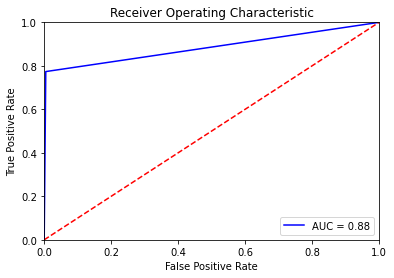

Confusion Matrix: 
 [[3596   17]
 [  43  147]]

Recall 'TP/TP+FN' =  0.7736842105263158


In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import recall_score
from sklearn.metrics import confusion_matrix

print(roc_auc_score(y_test, pred_ABC))

fpr, tpr, _ = roc_curve(y_test, pred_ABC)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred_ABC))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred_ABC))

In [ ]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier


rfc = RandomForestClassifier(n_jobs=-1,max_features= 'sqrt' ,n_estimators=50, oob_score = True) 

param_grid = { 
    'n_estimators': [200, 700],
    'max_features': ['auto', 'sqrt', 'log2']
}
# GridSearch of parameter tunning.
CV_rfc = GridSearchCV(estimator=rfc, param_grid=param_grid, cv= 5)
CV_rfc.fit(X_train, y_train)

c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(
c:\Users\thaka\anaconda3

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(max_features='sqrt',
                                              n_estimators=50, n_jobs=-1,
                                              oob_score=True),
             param_grid={'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': [200, 700]})

In [ ]:
pred=CV_rfc.predict(X_test)

c:\Users\thaka\anaconda3\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['quoted_name']. An error will be raised in 1.2.
  warnings.warn(


0.8943238597462381
AUC: 0.8943


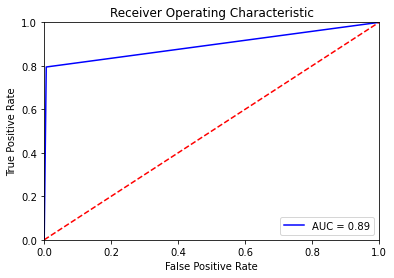

Confusion Matrix: 
 [[3591   22]
 [  39  151]]

Recall 'TP/TP+FN' =  0.7947368421052632


In [ ]:
print(roc_auc_score(y_test, pred))

fpr, tpr, _ = roc_curve(y_test, pred)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


print("Confusion Matrix: \n",confusion_matrix(y_test,pred))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,pred))

[19:27:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-07593ffd91cd9da33-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "silent" } are not used.

0.9822934724022898
AUC: 0.9823


c:\Users\thaka\anaconda3\lib\site-packages\xgboost\core.py:122: UserWarning: ntree_limit is deprecated, use `iteration_range` or model slicing instead.
  warnings.warn(


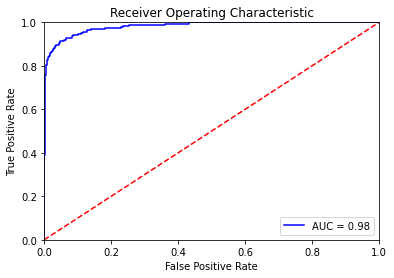

Confusion Matrix: 
 [[3590   23]
 [  38  152]]

Recall 'TP/TP+FN' =  0.8


In [ ]:
from sklearn.metrics import roc_curve, auc

dtrain = xgb.DMatrix(X_train[features], label=y_train)
dtest = xgb.DMatrix(X_test[features], label=y_test)
from xgboost import XGBClassifier
import matplotlib.pyplot as plt

param = {
        'objective': 'binary:logistic',
        'booster': 'gbtree',
        'eval_metric': 'auc',
        'max_depth': 6,  # the maximum depth of each tree
        'eta': 0.003,  # the training step for each iteration
        'silent': 1}  # logging mode - quiet}  # the number of classes that exist in this datset
num_round = 5000  # the number of training iterations    
bst = xgb.train(param, dtrain, num_round)
preds = bst.predict(dtest)

print (roc_auc_score(y_test, preds))
fpr, tpr, _ = roc_curve(y_test, preds)
roc_auc = auc(fpr, tpr)
print('AUC:', np.round(roc_auc,4))

ypred_bst = np.array(bst.predict(dtest,ntree_limit=bst.best_iteration))
ypred_bst  = ypred_bst > 0.5
ypred_bst = ypred_bst.astype(int)  

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
print("Confusion Matrix: \n",confusion_matrix(y_test,ypred_bst))
print("\nRecall 'TP/TP+FN' = ", recall_score(y_test,ypred_bst))

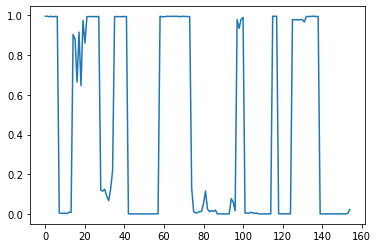

In [ ]:
dlive = xgb.DMatrix(df_predict[features]) #, label=[])
preds = bst.predict(dlive)

plt.plot(preds)
plt.show()

In [ ]:
live_set = df_predict[['date', 'place', 'latitude', 'longitude']]
live_set.loc[:,'quake'] = preds
# aggregate down dups
live_set = live_set.groupby(['date', 'place'], as_index=False).mean()

# increment date to include DAYS_OUT_TO_PREDICT
live_set['date']= pd.to_datetime(live_set['date'],format='%Y-%m-%d') 
live_set['date'] = live_set['date'] + pd.to_timedelta(7,unit='d')

live_set.tail()

C:\Users\thaka\AppData\Local\Temp\ipykernel_7020\2821658332.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  live_set.loc[:,'quake'] = preds


,date,place,latitude,longitude,quake
75,2020-08-18,Hawaii,19.282855,-155.420908,0.004697
76,2020-08-18,Indonesia,-4.186166,119.931170,0.994516
77,2020-08-18,Nevada,38.177047,-117.932016,0.000081
78,2020-08-18,Philippines,7.507142,125.354826,0.994352
79,2020-08-18,Puerto Rico,17.974638,-66.897354,0.917494


In [ ]:
live_set.head()

,date,place,latitude,longitude,quake
0,2020-08-05,Aleutian Islands,51.804107,102.265774,0.003171
1,2020-08-06,India,22.270152,93.567868,0.978504
2,2020-08-06,Philippines,7.507142,125.354826,0.994584
3,2020-08-07,India,22.270152,93.567868,0.934952
4,2020-08-07,Peru,-14.374907,-73.042380,0.993830


In [ ]:
import datetime as dt
# convert date to proper format for prediction
d2 = dt.datetime(2020,7,15)
days = list(set([d for d in live_set['date'].astype(str) if d > d2.strftime('%Y-%m-%d')]))
days.sort()

# Predict NaN outcome value in earthquake for next day 1.
predict_day=days[0]
predict_day

'2020-08-05'

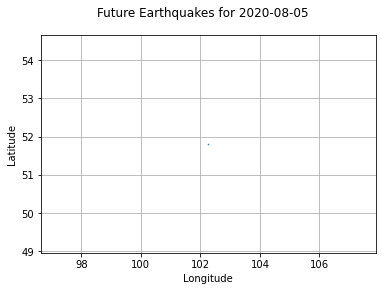

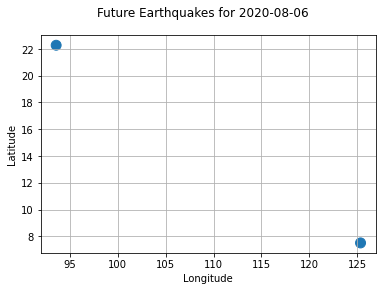

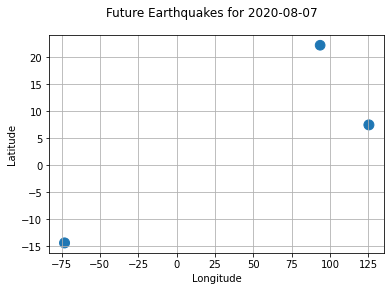

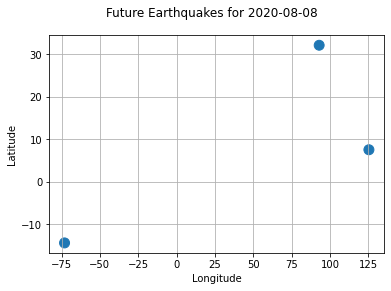

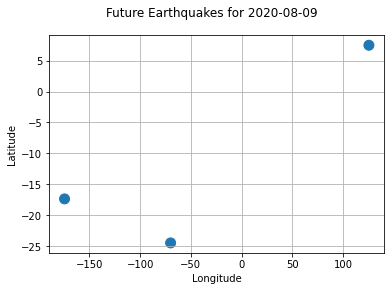

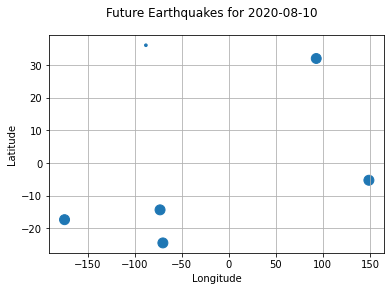

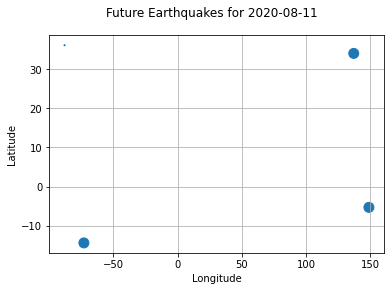

In [ ]:
# place, date, lat and long with earthquake probability for next 7 days
for i in range(0,7):
    live_set_tmp = live_set[live_set['date'] == days[i]]
    plt.scatter(live_set_tmp['longitude'], live_set_tmp['latitude'], s=(live_set_tmp['quake'] * 100))
    plt.suptitle('Future Earthquakes for ' + days[i])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid()  
    plt.show()